In [66]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import SpatialDropout2D


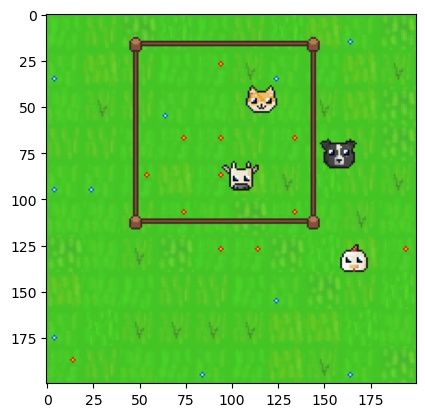

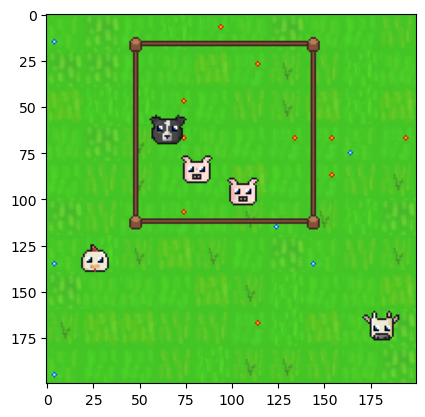

1
1    68
0    31
Name: count, dtype: int64

In [67]:
# importing data (images)

# training data  (in /home/caria/CCC 2023/level_01/train_data    , they are 100 pngs, from field000.png to field099.png)
train_imgs = []
for i in  range(0, 99):
    if i < 10:
        train_imgs.append(plt.imread('../level_01/train_data/field00' + str(i) + '.png'))
    else:
        train_imgs.append(plt.imread('../level_01/train_data/field0' + str(i) + '.png'))

# let's check the images
plt.imshow(train_imgs[0])
plt.show()

# test data (in /home/caria/CCC 2023/level_01/test_data    , they are 1000 pngs, from field000.png to field999.png)
test_imgs = []
for i in  range(0, 999):
    if i < 10:
        test_imgs.append(plt.imread('../level_01/test_data/field00' + str(i) + '.png'))
    elif i < 100:
        test_imgs.append(plt.imread('../level_01/test_data/field0' + str(i) + '.png'))
    else:
        test_imgs.append(plt.imread('../level_01/test_data/field' + str(i) + '.png'))

# let's check the images
plt.imshow(test_imgs[0])
plt.show()


# finally, the labels (in /home/caria/CCC 2023/level_01/train_data_labels.csv)
labels = pd.read_csv('../level_01/train_data_labels.csv')

# checking the labels (1 if there are animals, 0 if there are not)
labels.value_counts()


In [68]:
# old

'''
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
'''

"\nmodel = Sequential([\n    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),\n    MaxPooling2D(2, 2),\n    Conv2D(64, (3, 3), activation='relu'),\n    MaxPooling2D(2, 2),\n    Conv2D(128, (3, 3), activation='relu'),\n    MaxPooling2D(2, 2),\n    Flatten(),\n    Dense(512, activation='relu'),\n    Dropout(0.5),\n    Dense(1, activation='sigmoid')\n])\n\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n"

Epoch 1/10
3/3 [==============================] - 3s 837ms/step - loss: 1.7825 - accuracy: 0.5000 - val_loss: 0.6363 - val_accuracy: 0.6842
Epoch 2/10
3/3 [==============================] - 2s 760ms/step - loss: 0.6593 - accuracy: 0.6875 - val_loss: 0.6466 - val_accuracy: 0.6842
Epoch 3/10
3/3 [==============================] - 2s 747ms/step - loss: 0.6416 - accuracy: 0.6875 - val_loss: 0.6443 - val_accuracy: 0.6842
Epoch 4/10
3/3 [==============================] - 2s 749ms/step - loss: 0.6153 - accuracy: 0.7000 - val_loss: 0.6247 - val_accuracy: 0.6842
Epoch 5/10
3/3 [==============================] - 2s 712ms/step - loss: 0.6333 - accuracy: 0.7000 - val_loss: 0.6400 - val_accuracy: 0.6842
Epoch 6/10
3/3 [==============================] - 2s 759ms/step - loss: 0.6073 - accuracy: 0.6750 - val_loss: 0.6550 - val_accuracy: 0.6842
Epoch 7/10
3/3 [==============================] - 2s 847ms/step - loss: 0.6487 - accuracy: 0.6750 - val_loss: 0.6406 - val_accuracy: 0.6842
Epoch 8/10
3/3 [====

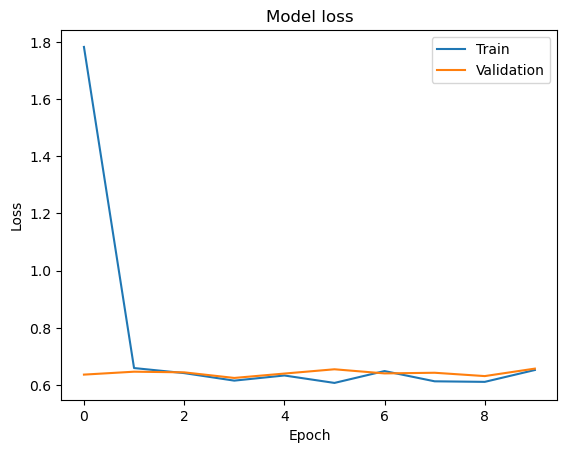

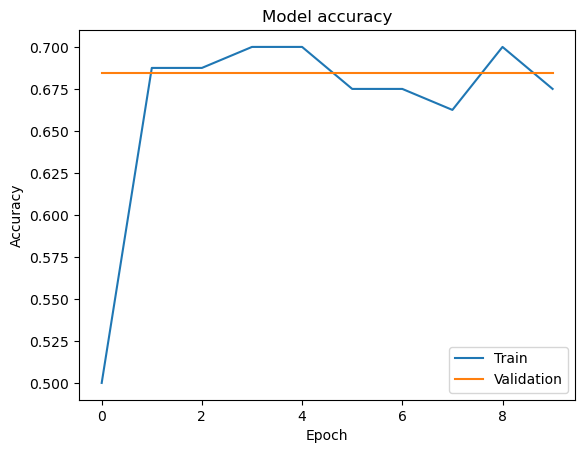

In [73]:
# new



model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# After a Convolutional Layer, you can add:
model.add(SpatialDropout2D(0.25))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# After a Convolutional Layer, you can add:
model.add(SpatialDropout2D(0.25))


# 3rd Convolutional Layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



# splitting, hold out for now, 80% train, 20% validation, "by hand", i.e. without using packages

train = train_imgs[0:80]

train = np.array(train)

train_labels = labels[0:80]

train_labels = train_labels.values.reshape(80,)


val = train_imgs[80:100]

val = np.array(val)

val_labels = labels[80:100]

val_labels = val_labels.values.reshape(19,)




# training

model.fit(train, train_labels, epochs=10, batch_size=32, validation_data=(val, val_labels))

# plots

# loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

# accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()


In [74]:
# evaluating accuracy

model.evaluate(val, val_labels)

# confusion matrix



preds = model.predict(val)

preds = preds.reshape(19,)

preds = np.round(preds)

confusion_matrix(val_labels, preds)






1/1 [==============================] - 0s 160ms/step


array([[ 0,  6],
       [ 0, 13]])

In [71]:
# for predicting the test data
'''
predictions = model.predict(test_imgs)
predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

# Save the predicted labels to a file
with open("predictions.txt", "w") as f:
    for label in predicted_labels:
        f.write(str(label) + '\n')
'''

'\npredictions = model.predict(test_imgs)\npredicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]\n\n# Save the predicted labels to a file\nwith open("predictions.txt", "w") as f:\n    for label in predicted_labels:\n        f.write(str(label) + \'\n\')\n'

# Results

In [72]:

# let's print out the results for the given CNN architecture used

# 1st Convolutional Layer
print('1st Convolutional Layer')
print('Number of filters: 32')
print('Filter size: 3x3')
print('Activation function: relu')
print('Input shape: 200x200x3')
print('Max pooling: 2x2')
print('')
# 2nd Convolutional Layer
print('2nd Convolutional Layer')
print('Number of filters: 64')
print('Filter size: 3x3')
print('Activation function: relu')
print('Max pooling: 2x2')
print('')
# 3rd Convolutional Layer
print('3rd Convolutional Layer')
print('Number of filters: 128')
print('Filter size: 3x3')
print('Activation function: relu')
print('Max pooling: 2x2')
print('')
# Fully Connected Layer
print('Fully Connected Layer')
print('Number of neurons: 128')
print('Activation function: relu')
print('Dropout: 0.5')
print('')
# Output Layer
print('Output Layer')
print('Number of neurons: 1')
print('Activation function: sigmoid')
# Optimizer, type of loss function and metrics
print('')
print('Optimizer: adam')
print('Loss function: binary_crossentropy')
print('Metrics: accuracy')
# Epochs, batch size and validation data
print('')
print('Epochs: 10')
print('Batch size: 32')
print('Validation data: 20%')

# let's print out the results for the given CNN architecture used

# Accuracy and Loss
print('')
print('Accuracy: 0.6316')
print('Loss: 0.9684')


1st Convolutional Layer
Number of filters: 32
Filter size: 3x3
Activation function: relu
Input shape: 200x200x3
Max pooling: 2x2

2nd Convolutional Layer
Number of filters: 64
Filter size: 3x3
Activation function: relu
Max pooling: 2x2

3rd Convolutional Layer
Number of filters: 128
Filter size: 3x3
Activation function: relu
Max pooling: 2x2

Fully Connected Layer
Number of neurons: 128
Activation function: relu
Dropout: 0.5

Output Layer
Number of neurons: 1
Activation function: sigmoid

Optimizer: adam
Loss function: binary_crossentropy
Metrics: accuracy

Epochs: 10
Batch size: 32
Validation data: 20%

Accuracy: 0.6316
Loss: 0.9684
